# Step 1: Prepare EN/FR pairs dataset

In [154]:
import os
import json
from laws_clir.load_xml import get_dict_from_xml

keep_keys = ["text", "section_str", "doc_title", "heading_str"]

sections = {"eng": {}, "fra": {}}
for lang, dir_name in [("eng", "acts"), ("fra", "lois")]:
    acts_dir = os.path.join(os.getcwd(), "laws-lois-xml", lang, dir_name)
    for file in os.listdir(acts_dir):
        if file.endswith(".xml"):
            xml_dict = get_dict_from_xml(os.path.join(acts_dir, file))
            for section in xml_dict["all_chunkable_sections"]:
                sections[lang][section["section_id"].replace(f"_{lang}_", "_")] = {
                    k: v for k, v in section.items() if k in keep_keys
                }

with open("acts.json", "w") as f:
    json.dump(sections, f, indent=2)

In [155]:
sections = {"eng": {}, "fra": {}}
for lang, dir_name in [("eng", "regulations"), ("fra", "reglements")]:
    acts_dir = os.path.join(os.getcwd(), "laws-lois-xml", lang, dir_name)
    for file in os.listdir(acts_dir):
        if file.endswith(".xml"):
            xml_dict = get_dict_from_xml(os.path.join(acts_dir, file))
            for section in xml_dict["all_chunkable_sections"]:
                sections[lang][section["section_id"].replace(f"_{lang}_", "_")] = {
                    k: v for k, v in section.items() if k in keep_keys
                }

with open("regulations.json", "w") as f:
    json.dump(sections, f, indent=2)

In [176]:
# Transform to single dataframe
import pandas as pd

with open("acts.json", "r") as f:
    sections = json.load(f)

print("Comparing acts...")
print(len(sections["eng"]), "sections found in English")
print(len(sections["fra"]), "sections found in French\n")
en_fr_sections = {}
for k in sections["eng"]:
    en_fr_sections[k] = {
        f"{k_}_eng": v_ for k_, v_ in sections["eng"][k].items()
    }
    if k in sections["fra"]:
        en_fr_sections[k].update({
            f"{k_}_fra": v_ for k_, v_ in sections["fra"][k].items()
        })
for k in sections["fra"]:
    if k not in sections["eng"]:
        en_fr_sections[k] = {
            f"{k_}_fra": v_ for k_, v_ in sections["fra"][k].items()
        }

df_acts = pd.DataFrame(en_fr_sections).T
df_acts["type"] = "act"

Comparing acts...
143031 sections found in English
143167 sections found in French



In [177]:
with open("regulations.json", "r") as f:
    sections = json.load(f)

print("Comparing regulations...")
print(len(sections["eng"]), "sections found in English")
print(len(sections["fra"]), "sections found in French\n")
en_fr_sections = {}
for k in sections["eng"]:
    en_fr_sections[k] = {
        f"{k_}_eng": v_ for k_, v_ in sections["eng"][k].items()
    }
    if k in sections["fra"]:
        en_fr_sections[k].update({
            f"{k_}_fra": v_ for k_, v_ in sections["fra"][k].items()
        })
for k in sections["fra"]:
    if k not in sections["eng"]:
        en_fr_sections[k] = {
            f"{k_}_fra": v_ for k_, v_ in sections["fra"][k].items()
        }

df_regs = pd.DataFrame(en_fr_sections).T
df_regs["type"] = "regulation"

df = pd.concat([df_acts, df_regs], axis=0)

Comparing regulations...
135204 sections found in English
135202 sections found in French



In [202]:
from collections import defaultdict

print(len(df), "sections/subsections/schedules/preambles found in total (either or both languages)")
print(sum(df["text_eng"].isna() | df["text_fra"].isna()), "sections/subsections/schedules/preambles with at least 1 missing language")

# Make a list of the IDs of the sections that are missing in one language
missing_ids = list(df[df["text_eng"].isna() | df["text_fra"].isna()].index)
# Remove anything from the text of "missing_ids" after, and including, the first occurrence of "section" or "subsection"
missing_matches = defaultdict(int)
for i, m in enumerate(missing_ids):
    if len(m.split("_section")) > 1:
        missing_ids[i] = m.split("_section")[0]
        missing_matches["section"] += 1
    elif len(m.split("_subsection")) > 1:
        missing_ids[i] = m.split("_subsection")[0]
        missing_matches["subsection"] += 1
    elif len(m.split("_schedule")) > 1:
        missing_ids[i] = m.split("_schedule")[0]
        missing_matches["schedule"] += 1
    elif len(m.split("_preamble")) > 1:
        missing_ids[i] = m.split("_preamble")[0]
        missing_matches["preamble"] += 1
# Remove duplicates
missing_ids = list(set(missing_ids))    
print(len(missing_ids), "unique documents with at least 1 missing language in a section/subsection/schedule/preamble")
for k, v in missing_matches.items():
    print(f"{v} missing {k}s")

284102 sections/subsections/schedules/preambles found in total (either or both languages)
11600 sections/subsections/schedules/preambles with at least 1 missing language
2094 unique documents with at least 1 missing language in a section/subsection/schedule/preamble
8212 missing schedules
1333 missing subsections
1880 missing sections
175 missing preambles


In [205]:
for k in keep_keys:
    for lang in ["eng", "fra"]:
        df[f"{k}_{lang}"] = df[f"{k}_{lang}"].fillna("").astype(str)

In [206]:
# We want to limit to certain number of tokens, to make length appropriate for embedding model
import tiktoken
def num_tokens_from_string(string: str, model: str = "gpt-4") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Count length of each eng/fra text, and the number of tokens in each
df["char_cnt_eng"] = df["text_eng"].apply(len)
df["char_cnt_fra"] = df["text_fra"].apply(len)
df["token_cnt_eng"] = df["text_eng"].apply(num_tokens_from_string)
df["token_cnt_fra"] = df["text_fra"].apply(num_tokens_from_string)

In [207]:
# Save CSV, zipped
df.to_csv("laws.csv.zip", compression="zip")

In [208]:
# We can remove the JSON files safely now
os.remove("acts.json")
os.remove("regulations.json")

64887 sections are between 128 and 1024 tokens in both languages


C:\Users\jkuehn\AppData\Local\Temp\ipykernel_5712\3980998432.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df["doc_id"] = doc_ids
C:\Users\jkuehn\AppData\Local\Temp\ipykernel_5712\3980998432.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df["section_id"] = trimmed_df.index


,text_eng,heading_str_eng,section_str_eng,doc_title_eng,text_fra,heading_str_fra,section_str_fra,doc_title_fra,type,char_cnt_eng,char_cnt_fra,token_cnt_eng,token_cnt_fra,doc_id,section_id
31544,"**Communication media**\n(1) No person shall, ...",Promotion > Miscellaneous Provisions,Section 31,Tobacco and Vaping Products Act,"**Médias**\n(1) Il est interdit, à titre gratu...",Promotion > Dispositions diverses,Section 31,Loi sur le tabac et les produits de vapotage,act,915,970,189,263,T-11.5,T-11.5_section_31
26304,**Applications for employment**\nEvery person ...,Offences Triable by Civil Courts > Offences,Section 307,National Defence Act,**Demandes d’emploi**\nCommet une infraction e...,Infractions du ressort des tribunaux civils et...,Section 307,Loi sur la défense nationale,act,872,912,193,272,N-5,N-5_section_307
22968,"**Idem**\nFor the purposes of subsection (8), ...","Income Tax Application Rules, 1971 > Special T...",Subsection 26(8.1),Income Tax Application Rules,**Idem**\nPour l’application du paragraphe (8)...,Règles de 1971 concernant l’application de l’i...,Subsection 26(8.1),Règles concernant l’application de l’impôt sur...,act,612,644,128,182,I-3.31,I-3.31_subsection_26(8.1)
21171,**Designated amount**\nFor the purposes of sub...,Income Tax > Computation of Taxable Income,Subsection 110(1.2),Income Tax Act,**Montant désigné**\nPour l’application des pa...,Impôt sur le revenu > Calcul du revenu imposable,Subsection 110(1.2),Loi de l’impôt sur le revenu,act,834,801,177,232,I-3.3,I-3.3_subsection_110(1.2)
28725,"**Termination**\nSubject to section 21.14, an ...",Use of Patents for International Humanitarian ...,Section 21.13,Patent Act,**Expiration de l’autorisation**\nSous réserve...,Usage de brevets à des fins humanitaires inter...,Section 21.13,Loi sur les brevets,act,1248,1063,288,340,P-4,P-4_section_21.13
12242,"Subject to subsection (2) and section 6, goods...",Group 2 of the Guide,Subsection 3(1),Defence Production Act,Sous réserve du paragraphe (2) et de l’article...,Groupe 2 du Guide,Subsection 3(1),Loi sur la production de défense,act,751,972,428,539,D-1,D-1_subsection_3(1)
31595,**Proceedings after five years**\nIn proceedin...,Geographical Indications,Subsection 11.19(2),Trademarks Act,**Procédures après cinq ans**\nDans le cas de ...,Indications géographiques,Subsection 11.19(2),Loi sur les marques de commerce,act,707,668,135,184,T-13,T-13_subsection_11.19(2)
40192,**Appeal management**\n(1) If the registrar is...,"Appeal Management, Chambers Sittings and Adjou...",Section 32,The Court of Appeal Criminal Appeal Rules (Sas...,**Gestion des appels**\n(1) Si le registraire ...,"Gestion des appels, séances en cabinet et reports",Section 32,Règles de la Cour d’appel régissant les appels...,regulation,1032,1054,224,324,SI-2011-9,SI-2011-9_section_32
42926,"(1) If it is filed, any document that is subje...",General Rules > Filing of Sealed and Confident...,Section 19.1,Rules of the Supreme Court of Canada,"(1) S’il fait l’objet d’un dépôt, tout documen...",Règles générales > Dépôt de documents scellés ...,Section 19.1,Règles de la Cour suprême du Canada,regulation,1305,1716,292,486,SOR-2002-156,SOR-2002-156_section_19.1
63963,**Representations when applicant or appellant ...,Case Management and Dispute Resolution Service...,Section 382.3,Federal Courts Rules,**Prétentions du demandeur ou de l’appelant qu...,Gestion des instances et services de règlement...,Section 382.3,Règles des Cours fédérales,regulation,1371,1507,273,426,SOR-98-106,SOR-98-106_section_382.3


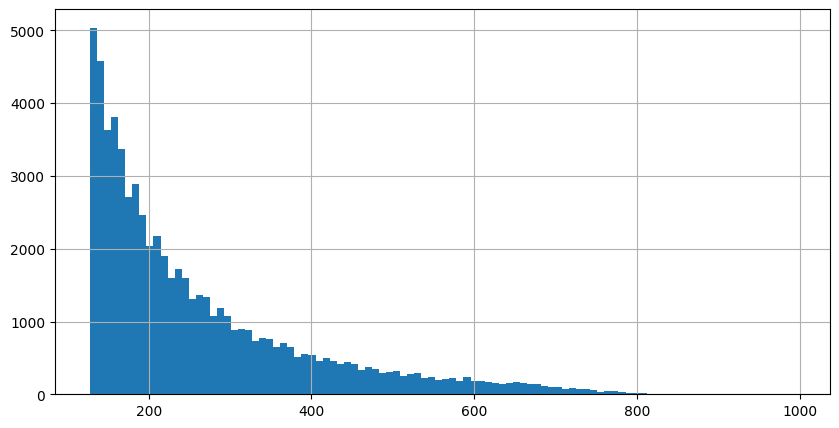

In [215]:
# Trim to only sections that are certain length in both languages
trimmed_df = df.query("token_cnt_eng <= 1024 and token_cnt_fra <= 1024 and token_cnt_eng >= 128 and token_cnt_fra >= 128")
print(trimmed_df.shape[0], "sections are between 128 and 1024 tokens in both languages")
# Add (matching between languages) document ID
doc_ids = list(trimmed_df.index)

for i, m in enumerate(doc_ids):
    if len(m.split("_section")) > 1:
        doc_ids[i] = m.split("_section")[0]
    elif len(m.split("_subsection")) > 1:
        doc_ids[i] = m.split("_subsection")[0]
    elif len(m.split("_schedule")) > 1:
        doc_ids[i] = m.split("_schedule")[0]
    elif len(m.split("_preamble")) > 1:
        doc_ids[i] = m.split("_preamble")[0]

trimmed_df["doc_id"] = doc_ids
trimmed_df["section_id"] = trimmed_df.index
trimmed_df.reset_index(drop=True, inplace=True)
trimmed_df = trimmed_df[[
    "doc_id",
    "section_id",
    "type",
    "doc_title_eng",
    "doc_title_fra",
    "section_str_eng",
    "section_str_fra",
    "heading_str_eng",
    "heading_str_fra",
    "text_eng",
    "text_fra",
    "char_cnt_eng",
    "char_cnt_fra",
    "token_cnt_eng",
    "token_cnt_fra",
]]

# Histogram of english token lengths
trimmed_df["token_cnt_eng"].hist(bins=100, figsize=(10, 5))

trimmed_df.sample(10)

C:\Users\jkuehn\AppData\Local\Temp\ipykernel_5712\1940494523.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df["doc_id"] = doc_ids
C:\Users\jkuehn\AppData\Local\Temp\ipykernel_5712\1940494523.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df["section_id"] = trimmed_df.index


,text_eng,heading_str_eng,section_str_eng,doc_title_eng,text_fra,heading_str_fra,section_str_fra,doc_title_fra,type,char_cnt_eng,char_cnt_fra,token_cnt_eng,token_cnt_fra,doc_id,section_id
SOR-2019-183_section_7,**Transfer of certain seized goods**\n(1) A pr...,Seizure and Detention,Section 7,Preclearance in Canada Regulations,**Transfert de certains biens saisis**\n(1) Le...,Saisie et détention,Section 7,Règlement sur le précontrôle au Canada,regulation,1041,1078,236,333,SOR-2019-183,SOR-2019-183_section_7
N-5_section_75,**Offences related to security**\nEvery person...,Code of Service Discipline > Service Offences ...,Section 75,National Defence Act,**Infraction et peine**\nCommet une infraction...,Code de discipline militaire > Infractions d’o...,Section 75,Loi sur la défense nationale,act,1547,1582,326,453,N-5,N-5_section_75
I-3.3_subsection_223(8),**Presentation of documents**\nIf\n(a) a memor...,Administration and Enforcement > Collection,Subsection 223(8),Income Tax Act,**Présentation des documents**\nL’extrait qui ...,Application et exécution > Recouvrement,Subsection 223(8),Loi de l’impôt sur le revenu,act,1313,1466,262,379,I-3.3,I-3.3_subsection_223(8)
F-11.75_section_30,**Notice of court or tribunal proceedings**\n(...,General,Section 30,First Nations Jurisdiction over Education in B...,**Avis : procédure judiciaire ou administrativ...,Dispositions générales,Section 30,Loi sur la compétence des premières nations en...,act,1331,1292,277,343,F-11.75,F-11.75_section_30
SOR-2018-144_section_88.93,**Identification and analysis of hazards**\n(1...,Good Production Practices > Additional Require...,Section 88.93,Cannabis Regulations,**Détermination et analyse des dangers**\n(1) ...,Bonnes pratiques de production > Exigences add...,Section 88.93,Règlement sur le cannabis,regulation,677,707,132,184,SOR-2018-144,SOR-2018-144_section_88.93
SOR-96-263_section_5,Hybrid animals that have in their recent linea...,Forfeiture,Section 5,Wild Animal and Plant Trade Regulations,"Les animaux hybrides qui, dans leur ascendance...",Confiscation,Section 5,Règlement sur le commerce d’espèces animales e...,regulation,818,924,157,255,SOR-96-263,SOR-96-263_section_5
E-14.1_subsection_43.1(2),**Annual adjustments**\nEach rate of duty set ...,Tobacco > Duty on Tobacco,Subsection 43.1(2),"Excise Act, 2001",**Ajustements annuels**\nChacun des taux de dr...,Tabac > Droit sur le tabac,Subsection 43.1(2),Loi de 2001 sur l’accise,act,955,1002,217,318,E-14.1,E-14.1_subsection_43.1(2)
SOR-96-13_section_6,(1) In order to conserve mineral resources and...,Conservation,Section 6,Public Lands Mineral Regulations,"(1) Le ministre, afin de conserver les ressour...",Conservation,Section 6,Règlement sur les minéraux des terres domaniales,regulation,800,810,159,220,SOR-96-13,SOR-96-13_section_6
SOR-2021-129_section_17,**Representation before Office of Registrar of...,Unauthorized Representation — Exemptions,Section 17,College of Patent Agents and Trademark Agents ...,**Représentation devant le bureau du registrai...,Représentation non autorisée – exceptions,Section 17,Règlement sur le Collège des agents de brevets...,regulation,629,645,128,178,SOR-2021-129,SOR-2021-129_section_17
P-7.01_subsection_8(1),"An employer shall ensure, with respect to its ...",Administration of Pension Plans,Subsection 8(1),"Pension Benefits Standards Act, 1985",L’employeur veille à ce que les montants suiva...,Gestion des régimes de pension,Subsection 8(1),Loi de 1985 sur les normes de prestation de pe...,act,894,757,202,215,P-7.01,P-7.01_subsection_8(1)


In [ ]:
# Save the trimmed CSV, zipped
trimmed_df.to_csv("laws_trimmed.csv.zip", compression="zip")